# Normalize IAM database.
- Normalization by line.
- Correct: shear, skew and resize over the baselines

## Input
    data/tesis/handwriting/databases/IAM/sources/lines

## Output
    data/tesis/handwriting/databases/IAM/words_normalized

In [352]:
#path_base = '/Users/jorge/'
path_base = '/home/vruiz/'

path = path_base + 'handwriting/data/IAM/'
 
data_path = '/home/abarreiro/data/handwriting/seq2seq/'


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.ndimage

import os
import cv2
import h5py
import sys

# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (30, 30)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap


In [148]:
path

'/home/vruiz/handwriting/data/IAM/'

In [151]:
a = [('j', 'o', 's', 'e', 'e', 'e')]
b = ['alvaro', 'victoria', 'jose', 'gavab']

c = ' '.join(b[2:])
print(c)

d = ''.join(b[2:])
print(d)


a.append(('a', 'l', 'v', 'a', 'r',' '.join(['o', 'b'])))
print(a)

a = pd.DataFrame(a, columns=['1','2', '3', '4', '5', '6'])

print(a.head)

jose gavab
josegavab
[('j', 'o', 's', 'e', 'e', 'e'), ('a', 'l', 'v', 'a', 'r', 'o b')]
<bound method NDFrame.head of    1  2  3  4  5    6
0  j  o  s  e  e    e
1  a  l  v  a  r  o b>


In [152]:
#Read list of words in pandas
array_words=[]
n=0
with open(path + 'ascii/words.txt', 'r') as f:
    array_words = []
    for line in f:
        if line[0] !='#': # avoids reading the commentaries
            lp = line.strip().split(' ') # strip() method removes spaces at the beggining and at the end of the string
            # split() method returns a list of the words in the string/line separated by the delimiter string (' ' in this case)
            n+=1
            array_words.append((lp[0],lp[1],lp[2],lp[3],lp[4],lp[5],lp[6],lp[7],' '.join(lp[8:]))) # column by column, it adds
            # the whole words.txt line to array_words in a tuple
            # ' '.join() method: joins elements of a list by ' ' (blank space)
print(len(array_words))

pd_words = pd.DataFrame(array_words, columns=['id_word','segmentation_result','graylevel_binarize',
                                              'x','y','w','h','grammar_tag','word'])
pd_words['w_char'] = pd_words.apply(lambda row: float(row['w']) / len(row['word']), axis=1) # width per character
pd_words['num_chars'] = pd_words.apply(lambda row: len(row['word']), axis=1) # characters per word
pd_words['line'] = pd_words.apply(lambda row: '-'.join(row['id_word'].split('-')[:-1]), axis=1) # lines: (e.g. a01-000u-00)
pd_words['page'] = pd_words.apply(lambda row: '-'.join(row['id_word'].split('-')[:-2]), axis=1) # page: (e.g. a01-000u)
# example: a01-000u-00-05 ---> page: a01-000u, line: 00, word: 05 

print(pd_words.head)
#115319

115320
<bound method NDFrame.head of                id_word segmentation_result graylevel_binarize     x     y  \
0       a01-000u-00-00                  ok                154   408   768   
1       a01-000u-00-01                  ok                154   507   766   
2       a01-000u-00-02                  ok                154   796   764   
3       a01-000u-00-03                  ok                154   919   757   
4       a01-000u-00-04                  ok                154  1185   754   
5       a01-000u-00-05                  ok                154  1438   746   
6       a01-000u-00-06                  ok                154  1896   757   
7       a01-000u-01-00                  ok                156   395   932   
8       a01-000u-01-01                  ok                156   901   958   
9       a01-000u-01-02                  ok                156  1112   958   
10      a01-000u-01-03                  ok                156  1400   937   
11      a01-000u-01-04                 

In [153]:
# Clean incorrect words. Select 'segmentation_result == "ok" and word <> "#"'
pd_select_words = pd_words.query('segmentation_result == "ok" and word != "#"')
# que la segmentación sea buena y que no contengan tachones
print(pd_select_words.head)
# 96391

<bound method NDFrame.head of                id_word segmentation_result graylevel_binarize     x     y  \
0       a01-000u-00-00                  ok                154   408   768   
1       a01-000u-00-01                  ok                154   507   766   
2       a01-000u-00-02                  ok                154   796   764   
3       a01-000u-00-03                  ok                154   919   757   
4       a01-000u-00-04                  ok                154  1185   754   
5       a01-000u-00-05                  ok                154  1438   746   
6       a01-000u-00-06                  ok                154  1896   757   
7       a01-000u-01-00                  ok                156   395   932   
8       a01-000u-01-01                  ok                156   901   958   
9       a01-000u-01-02                  ok                156  1112   958   
10      a01-000u-01-03                  ok                156  1400   937   
11      a01-000u-01-04                  ok    

In [154]:
#IAM partition train-valid-test
train_lines = pd.read_csv('/home/abarreiro/jorge/split/train.txt', names=['line'])
train_lines['page'] = train_lines.line.apply(lambda x: '-'.join(x.split('-')[:-1]))
train_lines.drop('line', axis=1, inplace=True)
train_lines.drop_duplicates(inplace=True) 


valid_lines = pd.read_csv('/home/abarreiro/jorge/split/valid.txt', names=['page'])
test_lines = pd.read_csv('/home/abarreiro/jorge/split/eval.txt', names=['page'])
train_lines['partition'] = 0
valid_lines['partition'] = 1
test_lines['partition'] = 2

print(train_lines.shape)
print(valid_lines.shape)
print(test_lines.shape)

partition = pd.concat([train_lines, valid_lines, test_lines])

partition

(747, 2)
(116, 2)
(336, 2)


,page,partition
0,a01-000u,0
7,a01-003u,0
18,a01-007u,0
28,a01-011u,0
38,a01-014u,0
46,a01-020u,0
55,a01-026u,0
66,a01-030u,0
77,a01-043u,0
86,a01-049u,0


In [155]:

pd_select_words = pd_select_words.merge(partition, on='page', how='left')
pd_select_words


,id_word,segmentation_result,graylevel_binarize,x,y,w,h,grammar_tag,word,w_char,num_chars,line,page,partition
0,a01-000u-00-00,ok,154,408,768,27,51,AT,A,27.000000,1,a01-000u-00,a01-000u,0.0
1,a01-000u-00-01,ok,154,507,766,213,48,NN,MOVE,53.250000,4,a01-000u-00,a01-000u,0.0
2,a01-000u-00-02,ok,154,796,764,70,50,TO,to,35.000000,2,a01-000u-00,a01-000u,0.0
3,a01-000u-00-03,ok,154,919,757,166,78,VB,stop,41.500000,4,a01-000u-00,a01-000u,0.0
4,a01-000u-00-04,ok,154,1185,754,126,61,NPT,Mr.,42.000000,3,a01-000u-00,a01-000u,0.0
5,a01-000u-00-05,ok,154,1438,746,382,73,NP,Gaitskell,42.444444,9,a01-000u-00,a01-000u,0.0
6,a01-000u-00-06,ok,154,1896,757,173,72,IN,from,43.250000,4,a01-000u-00,a01-000u,0.0
7,a01-000u-01-00,ok,156,395,932,441,100,VBG,nominating,44.100000,10,a01-000u-01,a01-000u,0.0
8,a01-000u-01-01,ok,156,901,958,147,79,DTI,any,49.000000,3,a01-000u-01,a01-000u,0.0
9,a01-000u-01-02,ok,156,1112,958,208,42,AP,more,52.000000,4,a01-000u-01,a01-000u,0.0


In [362]:
print(pd_select_words['partition'].value_counts())

0.0    47952
2.0    20306
1.0     7558
Name: partition, dtype: int64
0.0    47952
2.0    20306
1.0     7558
Name: partition, dtype: int64


# Create normalized words

In [303]:
from sklearn import linear_model
import math
from scipy import ndimage


# Normalization functions
def shear_angle(img, treshold_up = 100, treshold_down = 100):
    '''
    Find shear angle:
    - Check the upper neighboords of pixels with left blank
    '''
    C = 0
    L = 0
    R = 0
    for w in range(1, img.shape[1]-1): 
        for h in range(2, img.shape[0] - 1):
            if img[h,w] > treshold_up and img[h, w-1] < treshold_down:
                if img[h-1, w-1] > treshold_up:
                    L +=1

                elif img[h-1, w] > treshold_up:
                    C += 1

                elif img[h-1, w+1] > treshold_up:
                    R += 1

    return np.arctan2((R-L), (L+C+R))



def detect_baseline(img, treshold=20):
    '''
    detect baseline
    '''
    low = [] # inicializamos una lista vacía
    for w in range(1, img.shape[1] - 1): # para todo el rango de píxeles de izquierda a derecha
        if np.max(img[:,w]) > treshold: # si esa columna de píxels tiene alguno mínimamente blanco (threshold = umbral):
            for h in range(img.shape[0]-1, 0, -1): # recorremos toda la columna de abajo a arriba
                if img[h,w] > treshold: # si el píxel es más blanco que el umbral
                    low += [[h,w]] # lo añadimos a la lista (forma parte de la línea base del texto)
                    break # una vez lo he almacenado, paso a la siguiente columna
    points_lower = np.array(low) # convertimos la lista en array de numpy
    
    #Robust outliers regression:    
    x = points_lower[:,1].reshape(points_lower.shape[0],1) # de todos los pixels en "low", x son las coord. horizontales 
    y = points_lower[:,0].reshape(points_lower.shape[0],1) # y son las coord. verticales
    
    # los reshapes convierten estos vectores en vetores columna (2D-arrays)
    
    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression()) 
    model_ransac.fit(x, y) # aplicamos un ajuste RANSAC a estos puntos de la línea base
    y0 = model_ransac.predict(x[0].reshape(1, -1)) # aplicamos el ajuste a la primera coord. x de la línea base
    y1 = model_ransac.predict(x[-1].reshape(1, -1)) # ídem con la última 
    y_mean = model_ransac.predict(np.array([img.shape[1]/2]).reshape(1, -1)) # aplicamos el ajuste a la coordenada x media
    # para saber la altura media a la que está la línea base
    return y0, y1, int(y_mean), np.arctan((y1-y0)/(x[-1]-x[0]))*(180/math.pi)
    # np.arctan(...) calcula el ángulo de la línea base

def detect_upperline(img, treshold=20): # idéntica a la función anterior pero para calcular la línea superior
    '''
    detect upperline
    '''
    upp = []
    for w in range(1, img.shape[1] - 1):
        if np.max(img[:,w]) > treshold:
            for h in range(img.shape[0]): # para detectar la línea superior de texto recorremos la columna de arriba a abajo
                if img[h,w] > treshold:
                    upp += [[h,w]]
                    break
    points_upper = np.array(upp)
    
    #Robust outliers regression
    x = points_upper[:,1].reshape(points_upper.shape[0],1)
    y = points_upper[:,0].reshape(points_upper.shape[0],1)
    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
    model_ransac.fit(x, y)
    y0 = model_ransac.predict(x[0].reshape(1, -1))
    y1 = model_ransac.predict(x[-1].reshape(1, -1))  
    y_mean = model_ransac.predict(np.array([img.shape[1]/2]).reshape(1, -1)) 
    return y0, y1, int(y_mean)



def proccess_line(img, treshold=128):

    # Correct shear
    angle = shear_angle(img, treshold_up = treshold, treshold_down = treshold)
    M = np.float32([[1, -angle, 0.5*img.shape[0]*angle], [0, 1, 0]])
    img2 = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), flags=cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR)


    #Detect baseline to correct inclination
    y0, y1, y_mean, angle = detect_baseline(img2)
    # Correct inclination with lower angle
    img3 = ndimage.rotate(img2, angle)

    #Detect baseline
    y0, y1, y_mean_base, angle = detect_baseline(img3) 

    #Estimate Upper line
    y0, y1, y_mean_upper = detect_upperline(img2, treshold=treshold)

    percent_rescaled = 0.5 
    img_sup_rescaled = cv2.resize(img3[:y_mean_upper,:], (img3.shape[1],y_mean_upper//2)) # why in two steps?

    img_inf_rescaled = cv2.resize(img3[y_mean_base:,:], (img3.shape[1],(img3.shape[0] - y_mean_base)//2))

    img_rescaled = np.concatenate((img_sup_rescaled,img3[y_mean_upper:y_mean_base,:],img_inf_rescaled), axis=0) 
    # pegando los trozos (ha reducido el tamaño de los bordes superior e inferior)  

    return img_rescaled

In [304]:
# Test normalization
    
def create_words(line):
    #Read the umbralization treshold
    treshold = 255 - int(pd_select_words[pd_select_words['line']==line]['graylevel_binarize'].max()) # umbralizado en blanco

    #Read line image and normalize it
    part = line.split('-')
    line_image = '/home/abarreiro/data/lines/' + part[0] +'/' + part[0] + '-' + part[1] + '/' + line + '.png' # but we have words instead of lines...
    img = cv2.imread(line_image, cv2.IMREAD_GRAYSCALE)
    img = 255 - img

    try:
        img_rescaled = proccess_line(img, treshold = treshold)
    except:
        img_rescaled = img # in which case it might not work?
        print(line_image)
        
    # Save the normalized words
    words_line = pd_select_words[pd_select_words['line']==line]
    fig = plt.figure()
    words_list = []
    words_names = []

    for i, word in enumerate(words_line[:].iterrows()):
        words_names += [word[1].id_word]
        if i==0:
            base_position = int(word[1].x) 
        x_ini = int(word[1].x)
        w     = int(word[1].w)
        if w > 10: 
            words_list += [img_rescaled[:, x_ini - base_position : x_ini - base_position + w + 1]]
        else:
            words_list += [img_rescaled[:, x_ini - base_position - (10-w) : x_ini - base_position + w + (10-w)]]
    return img, img_rescaled, words_list, words_names


def save_word(path_normalized, word, img):
    sw = word.split('-')
    if not os.path.exists(path_normalized + sw[0]):
        os.makedirs(path_normalized + sw[0])
    if not os.path.exists(path_normalized + sw[0] + '/' + sw[0] + '-' + sw[1]):
        os.makedirs(path_normalized + sw[0] + '/' + sw[0] + '-' + sw[1])
    f = path_normalized + sw[0] + '/' + sw[0] + '-' + sw[1] + '/' + word + '.png'
    cv2.imwrite(f, 255-img)
    #plt.imshow(img)


['r06-143-04-00', 'r06-143-04-01', 'r06-143-04-02', 'r06-143-04-03', 'r06-143-04-04', 'r06-143-04-05', 'r06-143-04-06', 'r06-143-04-07', 'r06-143-04-08', 'r06-143-04-09', 'r06-143-04-10']


<Figure size 2160x2160 with 0 Axes>

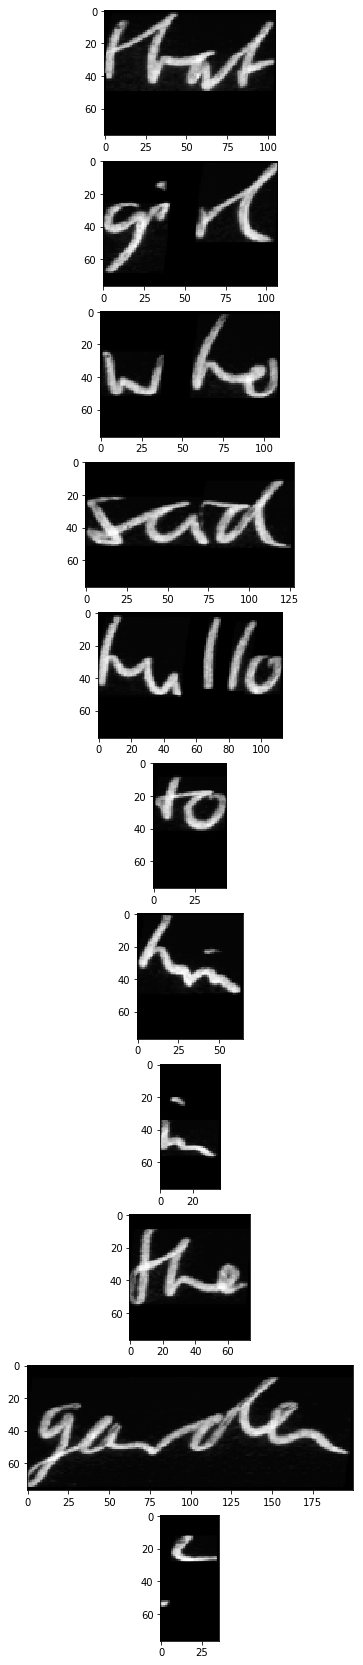

In [312]:
img, img_rescaled, word_list, words_names = create_words('r06-143-04')
print(words_names)
fig = plt.figure()
for i, word in enumerate(word_list):
    a=fig.add_subplot(len(word_list), 1, i+1)
    plt.imshow(word)


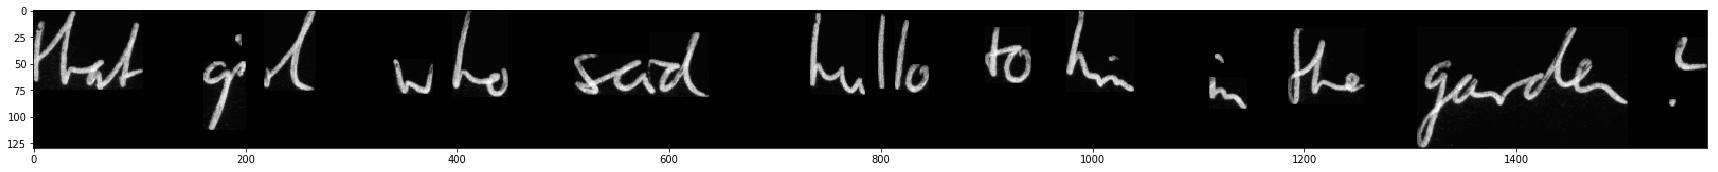

In [306]:
plt.imshow(img) 

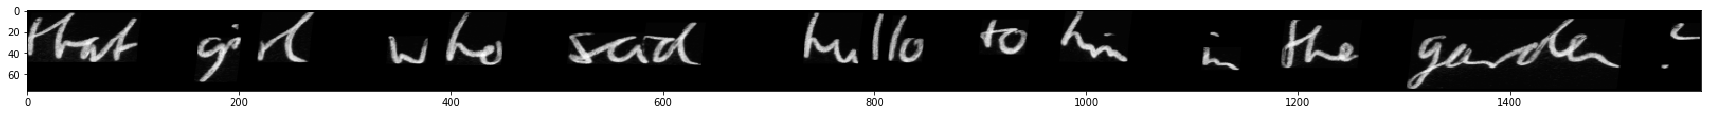

In [307]:
plt.imshow(img_rescaled) 

In [340]:
#
trn_lines = pd_select_words.loc[pd_select_words['partition'] == 0].line

for line in trn_lines:
    # Normalize line
    img_line, img_line_normalized, word_list, word_names = create_words(line)
    plt.close('all')
    #Save normalized lines
    #cv2.imwrite(path + 'lines_normalized/trn/' + line + '.png', 255-img_line_normalized)
    cv2.imwrite('/home/abarreiro/data/' + 'lines_normalized/trn/' + line + '.png', 255-img_line_normalized)
    # Save the normalized words
    for i, word in enumerate(word_names):
        save_word('/home/abarreiro/data/' + 'words_normalized/trn/', word, word_list[i])

print( 'Done!')

# Don't repeat more that 20 hours

/home/abarreiro/data/lines/a01/a01-072x/a01-072x-07.png
/home/abarreiro/data/lines/a01/a01-072x/a01-072x-07.png
/home/abarreiro/data/lines/a01/a01-072x/a01-072x-07.png
/home/abarreiro/data/lines/c03/c03-000f/c03-000f-04.png
/home/abarreiro/data/lines/c03/c03-000f/c03-000f-04.png
/home/abarreiro/data/lines/c03/c03-003f/c03-003f-04.png
/home/abarreiro/data/lines/c03/c03-003f/c03-003f-04.png
/home/abarreiro/data/lines/c03/c03-003f/c03-003f-04.png
/home/abarreiro/data/lines/c03/c03-003f/c03-003f-04.png
/home/abarreiro/data/lines/c03/c03-003f/c03-003f-04.png
/home/abarreiro/data/lines/c03/c03-007f/c03-007f-03.png
/home/abarreiro/data/lines/c03/c03-007f/c03-007f-03.png
/home/abarreiro/data/lines/c03/c03-007f/c03-007f-03.png
/home/abarreiro/data/lines/c03/c03-007f/c03-007f-05.png
/home/abarreiro/data/lines/c03/c03-007f/c03-007f-05.png
/home/abarreiro/data/lines/c03/c03-007f/c03-007f-05.png
/home/abarreiro/data/lines/c03/c03-007f/c03-007f-05.png
/home/abarreiro/data/lines/c03/c03-007f/c03-007f

In [341]:
val_lines = pd_select_words.loc[pd_select_words['partition'] == 1].line

for line in val_lines:
    # Normalize line
    img_line, img_line_normalized, word_list, word_names = create_words(line)
    plt.close('all')
    #Save normalized lines
    cv2.imwrite('/home/abarreiro/data/' + 'lines_normalized/val/' + line + '.png', 255-img_line_normalized)
    # Save the normalized words
    for i, word in enumerate(word_names):
        save_word('/home/abarreiro/data/' + 'words_normalized/val/', word, word_list[i])

print( 'Done!')
# Don't repeat more that 20 hours

Done!


In [342]:
tst_lines = pd_select_words.loc[pd_select_words['partition'] == 2].line

for line in tst_lines:
    # Normalize line
    img_line, img_line_normalized, word_list, word_names = create_words(line)
    plt.close('all')
    #Save normalized lines
    cv2.imwrite('/home/abarreiro/data/' + 'lines_normalized/tst/' + line + '.png', 255-img_line_normalized)
    # Save the normalized words
    for i, word in enumerate(word_names):
        save_word('/home/abarreiro/data/' + 'words_normalized/tst/', word, word_list[i])

print( 'Done!')
# Don't repeat more that 20 hours

/home/abarreiro/data/lines/f07/f07-019a/f07-019a-08.png
/home/abarreiro/data/lines/f07/f07-019a/f07-019a-08.png
/home/abarreiro/data/lines/m02/m02-055/m02-055-10.png
/home/abarreiro/data/lines/n02/n02-045/n02-045-08.png
/home/abarreiro/data/lines/n02/n02-045/n02-045-08.png
/home/abarreiro/data/lines/n02/n02-045/n02-045-08.png
Done!


# Step 2: create hdf5 file with fixed size images and targets

- Readed and filtered words list: pd_select_words
- For each, if normalized image exist: load and resize and cummulate in X, X_len, y and y_len.
- Create and save encoder-decoder dictionariy characters.


In [343]:
# Create character dictionary encoder and decoder
labels_trn = pd_select_words.loc[pd_select_words['partition'] == 0].word
labels_val = pd_select_words.loc[pd_select_words['partition'] == 1].word
labels_tst = pd_select_words.loc[pd_select_words['partition'] == 2].word

def char_set(df):
    c_list = []
    for w in df:
        c_list += w
    return set(c_list)

s_trn = char_set(labels_trn)
s_val = char_set(labels_val)
s_tst = char_set(labels_tst)

print('trn - tst: ', s_trn - s_tst)
print('tst - trn: ', s_tst - s_trn)
print('trn - val: ', s_trn - s_val)
print('val - trn: ', s_val - s_trn)

char_set = s_trn


encoder_dict = {}
decoder_dict = {}
list_chars = []
list_codes = []
for i, c in enumerate(char_set):
    encoder_dict[c]=i
    decoder_dict[i]=c
    list_chars += [c.encode('utf8')]
    list_codes += [i]
    
print(encoder_dict)
print(decoder_dict)
print(list_chars)
print(list_chars[0].decode('utf8'))

trn - tst:  {'/', '+', 'X', '*', 'Z'}
tst - trn:  set()
trn - val:  {'/', 'X', '&', '+'}
val - trn:  set()
{'.': 0, 'g': 1, 'k': 2, 's': 3, 'w': 4, '6': 5, '+': 6, 'I': 7, 'e': 8, 'm': 9, 'v': 10, '1': 11, 'U': 12, 'z': 13, 'F': 14, '"': 15, '&': 16, 'l': 17, 'G': 18, 'f': 19, 'y': 20, 'b': 21, 'A': 22, 'c': 23, '0': 24, '5': 25, ':': 26, 'o': 27, 'd': 28, 'W': 29, 't': 30, '!': 31, '-': 32, 'S': 33, 'D': 34, 'C': 35, '2': 36, 'Q': 37, 'P': 38, '?': 39, '/': 40, 'i': 41, 'E': 42, ')': 43, 'a': 44, 'N': 45, ' ': 46, '*': 47, 'J': 48, '7': 49, '3': 50, 'x': 51, 'Z': 52, 'p': 53, '(': 54, '9': 55, 'L': 56, '4': 57, 'u': 58, 'V': 59, '8': 60, 'r': 61, 'M': 62, 'h': 63, "'": 64, 'H': 65, 'O': 66, 'R': 67, ';': 68, 'X': 69, 'j': 70, 'Y': 71, 'B': 72, 'q': 73, ',': 74, 'n': 75, 'T': 76, 'K': 77}
{0: '.', 1: 'g', 2: 'k', 3: 's', 4: 'w', 5: '6', 6: '+', 7: 'I', 8: 'e', 9: 'm', 10: 'v', 11: '1', 12: 'U', 13: 'z', 14: 'F', 15: '"', 16: '&', 17: 'l', 18: 'G', 19: 'f', 20: 'y', 21: 'b', 22: 'A', 23

In [344]:
# Create character dictionary encoder and decoder
labels_trn = pd_select_words.loc[pd_select_words['partition'] == 0].word
labels_val = pd_select_words.loc[pd_select_words['partition'] == 1].word
labels_tst = pd_select_words.loc[pd_select_words['partition'] == 2].word


def char_set(df):
    c_list = []
    for w in df:
        c_list += w
    return set(c_list)

s_trn = char_set(labels_trn)
s_val = char_set(labels_val)
s_tst = char_set(labels_tst)

print('trn - tst: ', s_trn - s_tst)
print('tst - trn: ', s_tst - s_trn)
print('trn - val: ', s_trn - s_val)
print('val - trn: ', s_val - s_trn)

char_set = s_trn

# Dictionary used in seq2seq paper
decoder_dict = {0: '0', 1: '!', 2: 'L', 3: 'z', 4: 'G', 5: 'm', 6: '6', 7: '/', 8: 'j', 9: 's', 10: 'S', 11: '5',
                12: 'R', 13: ')', 14: 'u', 15: 'y', 16: '9', 17: 'g', 18: '3', 19: '1', 20: 'e', 21: "'", 22: ':',
                23: 'Q', 24: '2', 25: 'a', 26: 't', 27: 'A', 28: '7', 29: ';', 30: 'i', 31: 'H', 32: 'W', 33: ',',
                34: '(', 35: 'O', 36: 'U', 37: 'K', 38: 'd', 39: '*', 40: '.', 41: '?', 42: 'q', 43: '-', 44: 'r',
                45: 'n', 46: '&', 47: 'C', 48: '"', 49: 'h', 50: 'v', 51: 'f', 52: 'E', 53: 'p', 54: 'x', 55: '+',
                56: 'w', 57: 'b', 58: 'o', 59: ' ', 60: 'B', 61: 'P', 62: 'D', 63: 'I', 64: 'J', 65: 'V', 66: 'N',
                67: 'M', 68: '8', 69: 'k', 70: 'c', 71: '4', 72: 'T', 73: 'X', 74: 'l', 75: 'Z', 76: 'F', 77: 'Y'}


encoder_dict = {v: k for k, v in decoder_dict.items()}

list_chars = []
list_codes = []
for c in decoder_dict:
    list_chars += [decoder_dict[c].encode('utf8')]
    list_codes += [c]
    
print(encoder_dict)
print(decoder_dict)
print('-------------')
print(list_chars)
print(list_chars[0].decode('utf8'))

trn - tst:  {'/', '+', 'X', '*', 'Z'}
tst - trn:  set()
trn - val:  {'/', 'X', '&', '+'}
val - trn:  set()
{'0': 0, '!': 1, 'L': 2, 'z': 3, 'G': 4, 'm': 5, '6': 6, '/': 7, 'j': 8, 's': 9, 'S': 10, '5': 11, 'R': 12, ')': 13, 'u': 14, 'y': 15, '9': 16, 'g': 17, '3': 18, '1': 19, 'e': 20, "'": 21, ':': 22, 'Q': 23, '2': 24, 'a': 25, 't': 26, 'A': 27, '7': 28, ';': 29, 'i': 30, 'H': 31, 'W': 32, ',': 33, '(': 34, 'O': 35, 'U': 36, 'K': 37, 'd': 38, '*': 39, '.': 40, '?': 41, 'q': 42, '-': 43, 'r': 44, 'n': 45, '&': 46, 'C': 47, '"': 48, 'h': 49, 'v': 50, 'f': 51, 'E': 52, 'p': 53, 'x': 54, '+': 55, 'w': 56, 'b': 57, 'o': 58, ' ': 59, 'B': 60, 'P': 61, 'D': 62, 'I': 63, 'J': 64, 'V': 65, 'N': 66, 'M': 67, '8': 68, 'k': 69, 'c': 70, '4': 71, 'T': 72, 'X': 73, 'l': 74, 'Z': 75, 'F': 76, 'Y': 77}
{0: '0', 1: '!', 2: 'L', 3: 'z', 4: 'G', 5: 'm', 6: '6', 7: '/', 8: 'j', 9: 's', 10: 'S', 11: '5', 12: 'R', 13: ')', 14: 'u', 15: 'y', 16: '9', 17: 'g', 18: '3', 19: '1', 20: 'e', 21: "'", 22: ':', 23

In [345]:
# Check target length
print(np.max([len(t) for t in pd_select_words.loc[pd_select_words['partition'] == 0].word]))
print(np.max([len(t) for t in pd_select_words.loc[pd_select_words['partition'] == 1].word]))
print(np.max([len(t) for t in pd_select_words.loc[pd_select_words['partition'] == 2].word]))


19
16
21


(59, 232)
[255  74  66  86 144 186 203 213 212 157  91  89 135 196 211 195 159 132
 124 157 188 239 255 255 222 157  98  72  65  63  71  78  91  94  78  66
  71 133 206 247 254 255 132  75  97 152 181 161 129  96  77  63  63 119
 195 223 247 255 255 255 254 255 149  80  64  75 144 191 191 143  78  57
  61  75  98 107  89  76 106 217 255 255 255 255 255 231 170  88  67  93
 166 219 235 240 240 241 242 240 251 255 255 238 216 151  92  74  67  70
  81 103 117 130 146 148 142 121 108  97  93 117 194 245 255 255 255 255
 241 228 192 133  90  67  71  81  94  92  99 119 166 213 231 233 227 225
 246 255 152  88  65  65  88 170 219 229 233 235 230 166  84  66  72 135
 227 255 255 255 239 225 173 111  77  77 111 167 214 235 240 239 232 218
 201 168 127 107 103 117 115 161 215 247 255 255 254 255 167 121 109 108
 106  92  76  76  71  69  69  73  97 119 153 189 224 241 252 255 255 255
 255 255 217 143  99 105  92  81  80 110 164 213 237 247 249 253]


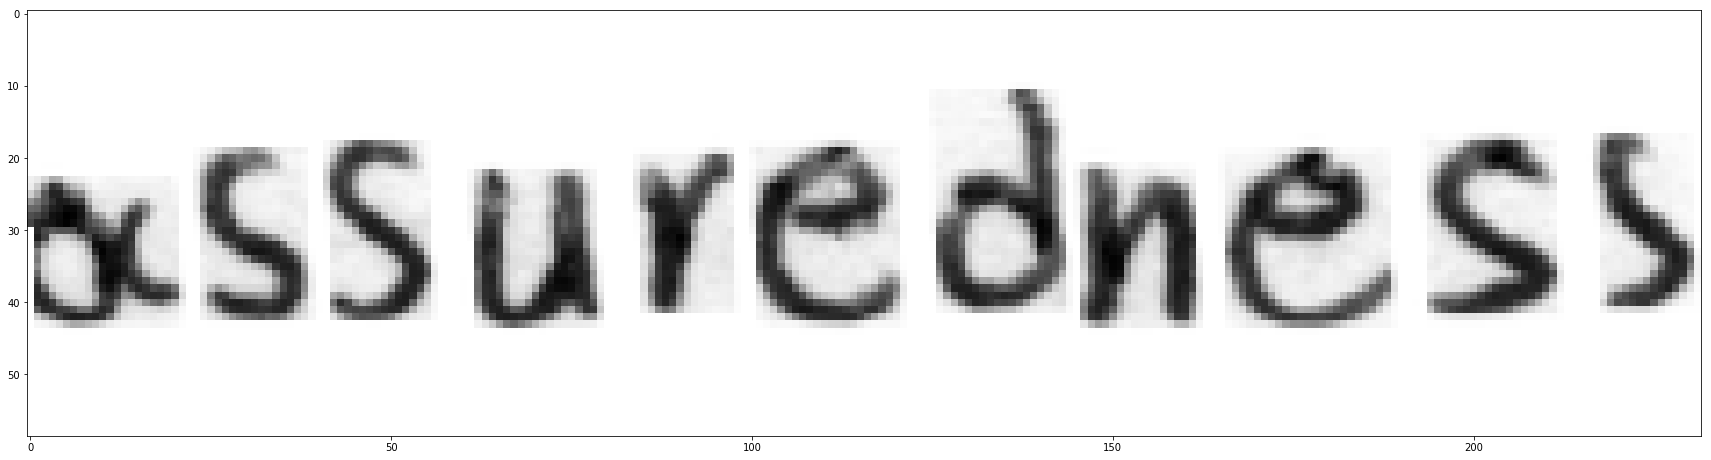

In [347]:
# Sample image
img = cv2.imread('/home/abarreiro/data/words_normalized/tst/c04/c04-110/c04-110-01-00.png', cv2.IMREAD_GRAYSCALE)
#img = cv2.imread(path + '/words_normalized/trn/a06/a06-075/a06-075-00-00.png', cv2.IMREAD_GRAYSCALE)
print(img.shape)
print(img[40])
plt.imshow(img)

187


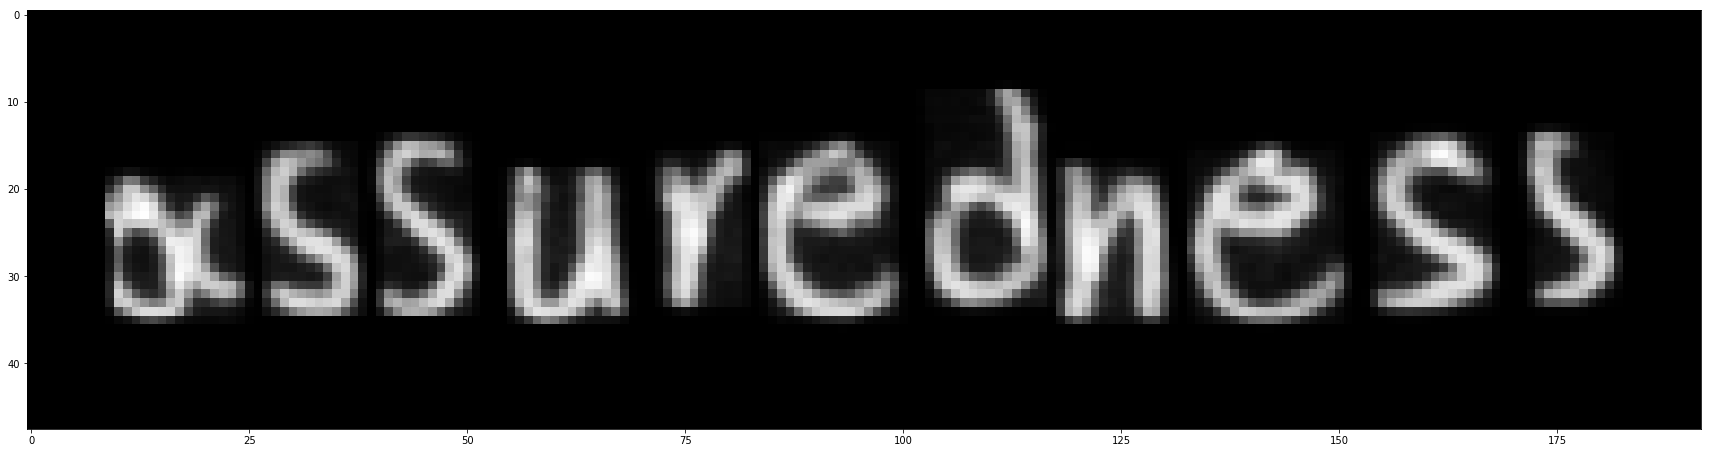

In [348]:
# The final shape must be 48 x 192
# if w > h*4 --> resize to (h, h*4)
# else complete at the left with 0
# Next resize to 48x192

def transform_image(img, x_size=192, y_size=48):

    # add treshold
    gray_level = np.vectorize(lambda x: 0 if x > 253 else 255-x) # why??? :
    img2 = gray_level(img)

    # Add borders
    h, w = img2.shape
    dh = int(h*0)
    dw = int(w*0.05)+1
    img3 = np.zeros([h+2*dh, w+2*dw], dtype=np.uint8)
    img3[:, dw:-dw] = img2

    # Resize
    h, w = img3.shape
    if w >= h*4:
        img4 = cv2.resize(img3, (h*4, h)) #shape in cv2 is [w,h]
    else:
        img4 = np.zeros([h, h*4], dtype=np.uint8)
        img4[:, 0:w] = img3
    img5 = cv2.resize(img4, (x_size, y_size)) 
    
    # Calculate length of the image: The last non-zero column + 5 
    col_sum = np.sum(i for i in img5)
    last_place = 0
    for i, s in enumerate(col_sum):
        if s > 1:
            last_place = i
    img_len = min(x_size, 5+last_place)
    return img5, img_len

img_t, img_len = transform_image(img)
plt.imshow(img_t)
print(img_len)

In [355]:

def transform_and_save(ds_type='trn', ds_id = 0, filename="IAM_words_48_192.hdf5", x_size=192, y_size=48):
    X = []
    image_length = []
    target = []
    target_length = []
    names_of_files = []
    max_target_len = 19

    for i, row in pd_select_words.loc[pd_select_words['partition'] == ds_id].iloc[:].iterrows():
        if i%1000==0:
            print(i)
        file_name = '/home/abarreiro/data/' + 'words_normalized/' + ds_type + '/' + row.page.split('-')[0] + '/' + row.page + '/' + row.id_word + '.png'
        if os.path.isfile(file_name) and len(row.word) <= max_target_len: 
            correct = True
            try:
                #Read image
                img = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
                img_t, img_len = transform_image(img, x_size=x_size, y_size=y_size)        
                t = np.ones([max_target_len])*100
                for j, c in enumerate(row.word):
                    t[j] = encoder_dict[c]
            except:
                correct = False
                print( 'Error in image ',i, file_name)
                print( 'Error: ', sys.exc_info()[0])
            if correct:
                X += [img_t]
                image_length += [img_len]
                target += [t]
                target_length += [len(row.word)]
                names_of_files += [row.id_word]
                


    # Save in HDF5
    with h5py.File(data_path + filename) as hdf5_f:
        if "X_" + ds_type in hdf5_f:
            del hdf5_f["X_" + ds_type]
        hdf5_f.create_dataset("X_" + ds_type, data = X) 

        if "image_length_" + ds_type in hdf5_f:
            del hdf5_f["image_length_" + ds_type]
        hdf5_f.create_dataset("image_length_" + ds_type, data = image_length) 

        if "target_"+ ds_type in hdf5_f:
            del hdf5_f["target_" + ds_type]
        hdf5_f.create_dataset("target_" + ds_type, data = target) 

        if "target_length_" + ds_type in hdf5_f:
            del hdf5_f["target_length_" + ds_type]
        hdf5_f.create_dataset("target_length_" + ds_type, data = target_length)  
        
        if "filename_" + ds_type in hdf5_f:
            del hdf5_f["filename_" + ds_type]
        names_of_files = [n.encode("ascii", "ignore") for n in names_of_files]
        hdf5_f.create_dataset("filename_" + ds_type, (len(names_of_files),1), 'S20', data = names_of_files)  
    print('Done!')

# Create file for 48x192 shape

In [356]:
with h5py.File(data_path + "IAM_words_48_192.hdf5") as hdf5_f:
    if "target_dict_keys" in hdf5_f:
        del hdf5_f["target_dict_keys"]
    hdf5_f.create_dataset("target_dict_keys", data = list_codes) 

    if "target_dict_values" in hdf5_f:
        del hdf5_f["target_dict_values"]
    hdf5_f.create_dataset("target_dict_values", data = list_chars) 


In [357]:
transform_and_save(ds_type='trn', ds_id = 0)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
Error in image  11802 /home/abarreiro/data/words_normalized/trn/a06/a06-075/a06-075-00-00.png
Error:  <class 'TypeError'>
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
28000
35000
36000
Error in image  36077 /home/abarreiro/data/words_normalized/trn/e04/e04-058/e04-058-05-00.png
Error:  <class 'TypeError'>
38000
39000
40000
41000
49000
Error in image  49129 /home/abarreiro/data/words_normalized/trn/g06/g06-011c/g06-011c-03-00.png
Error:  <class 'TypeError'>
Error in image  49997 /home/abarreiro/data/words_normalized/trn/g06/g06-011m/g06-011m-03-00.png
Error:  <class 'TypeError'>
50000
51000
Error in image  51030 /home/abarreiro/data/words_normalized/trn/g06/g06-018h/g06-018h-07-03.png
Error:  <class 'TypeError'>
52000
Error in image  52767 /home/abarreiro/data/words_normalized/trn/g06/g06-031b/g06-031b-00-00.png
Error:  <class 'TypeError'>
Error in image  52848 /home/abarreiro/data/wo

In [358]:
transform_and_save(ds_type='val', ds_id = 1)

30000
37000
48000
79000
80000
82000
84000
89000
Done!


In [359]:
transform_and_save(ds_type='tst', ds_id = 2)

27000
29000
Error in image  30767 /home/abarreiro/data/words_normalized/tst/d05/d05-013/d05-013-03-00.png
Error:  <class 'TypeError'>
31000
32000
33000
Error in image  33335 /home/abarreiro/data/words_normalized/tst/d07/d07-102/d07-102-02-00.png
Error:  <class 'TypeError'>
34000
42000
43000
44000
45000
46000
Error in image  46485 /home/abarreiro/data/words_normalized/tst/g02/g02-073/g02-073-00-00.png
Error:  <class 'TypeError'>
47000
78000
81000
Error in image  82807 /home/abarreiro/data/words_normalized/tst/m06/m06-031/m06-031-01-00.png
Error:  <class 'TypeError'>
Error in image  82959 /home/abarreiro/data/words_normalized/tst/m06/m06-056/m06-056-01-00.png
Error:  <class 'TypeError'>
83000
Error in image  83019 /home/abarreiro/data/words_normalized/tst/m06/m06-067/m06-067-00-00.png
Error:  <class 'TypeError'>
Error in image  83223 /home/abarreiro/data/words_normalized/tst/m06/m06-083/m06-083-06-00.png
Error:  <class 'TypeError'>
Error in image  83238 /home/abarreiro/data/words_normali

In [360]:
with h5py.File(data_path + "IAM_words_48_192.hdf5", mode='r') as hdf5_f:

    for d in hdf5_f.keys():
        print(hdf5_f[d].name, ' - ', len(hdf5_f[d]))

/X_trn  -  47926
/X_tst  -  20292
/X_val  -  7558
/filename_trn  -  47926
/filename_tst  -  20292
/filename_val  -  7558
/image_length_trn  -  47926
/image_length_tst  -  20292
/image_length_val  -  7558
/target_dict_keys  -  78
/target_dict_values  -  78
/target_length_trn  -  47926
/target_length_tst  -  20292
/target_length_val  -  7558
/target_trn  -  47926
/target_tst  -  20292
/target_val  -  7558


98 [ 25.  56.  25.  15. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100.] 4 [b'f04-074-01-04']


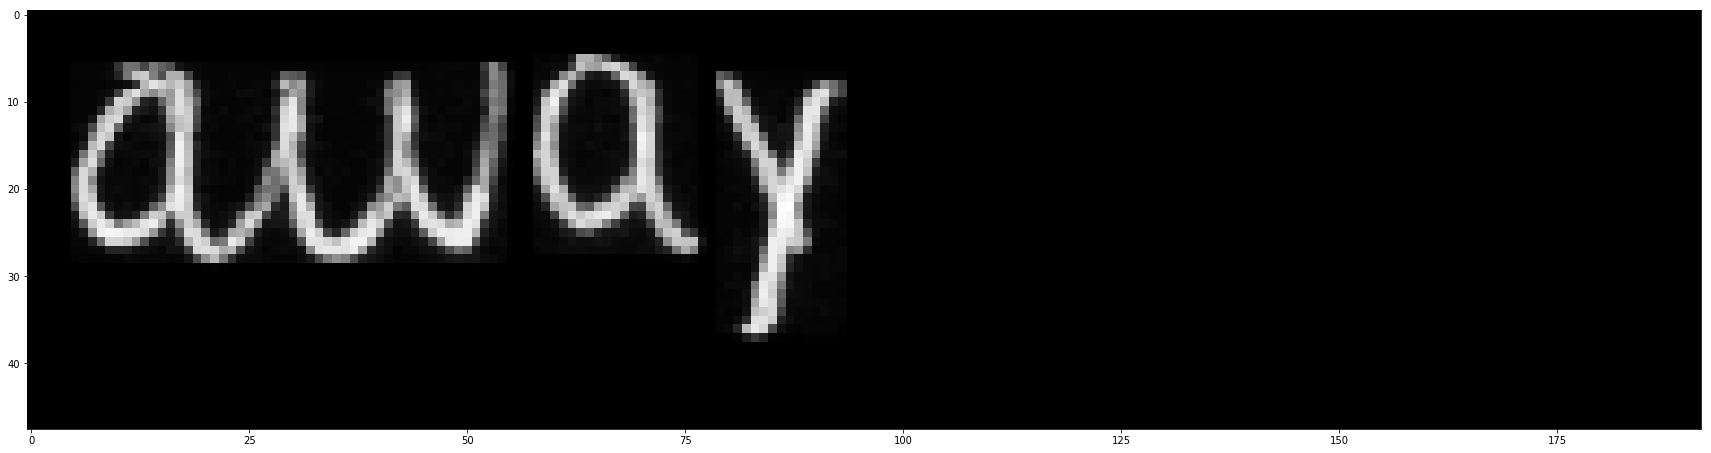

In [361]:
#Check data
i=5900
with h5py.File(data_path + "IAM_words_48_192.hdf5", mode='r') as hdf5_f:
    plt.imshow(hdf5_f.get('X_tst')[i])
    print(hdf5_f.get('image_length_tst')[i], hdf5_f.get('target_tst')[i],
          hdf5_f.get('target_length_tst')[i], hdf5_f.get('filename_tst')[i])

In [363]:
pd_select_words.head()

,id_word,segmentation_result,graylevel_binarize,x,y,w,h,grammar_tag,word,w_char,num_chars,line,page,partition
0,a01-000u-00-00,ok,154,408,768,27,51,AT,A,27.00,1,a01-000u-00,a01-000u,0.0
1,a01-000u-00-01,ok,154,507,766,213,48,NN,MOVE,53.25,4,a01-000u-00,a01-000u,0.0
2,a01-000u-00-02,ok,154,796,764,70,50,TO,to,35.00,2,a01-000u-00,a01-000u,0.0
3,a01-000u-00-03,ok,154,919,757,166,78,VB,stop,41.50,4,a01-000u-00,a01-000u,0.0
4,a01-000u-00-04,ok,154,1185,754,126,61,NPT,Mr.,42.00,3,a01-000u-00,a01-000u,0.0


In [464]:
import h5py
filename = "/home/abarreiro/data/handwriting/seq2seq/IAM_words_48_192.hdf5"

with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    data_header = list(f.keys())
    print(data_header)
    data = []
    for item in data_header:
        
        # Getting data:
        data.append(list(f[item]))
        
    # Creating dictionary between data names and data   
    new_dict = {name: obj for name, obj in zip(data_header, data)}


Keys: KeysView(<HDF5 file "IAM_words_48_192.hdf5" (mode r)>)
['X_trn', 'X_tst', 'X_val', 'filename_trn', 'filename_tst', 'filename_val', 'image_length_trn', 'image_length_tst', 'image_length_val', 'target_dict_keys', 'target_dict_values', 'target_length_trn', 'target_length_tst', 'target_length_val', 'target_trn', 'target_tst', 'target_val']
X_trn
X_tst
X_val
filename_trn
filename_tst
filename_val
image_length_trn
image_length_tst
image_length_val
target_dict_keys
target_dict_values
target_length_trn
target_length_tst
target_length_val
target_trn
target_tst
target_val


In [507]:
print(new_dict['target_trn'][26])

[ 58.  45. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100.]


In [521]:
print(len(new_dict['X_trn']))
print(new_dict['X_trn'][1].shape)
print(new_dict['target_dict_values'][1])
print(max(new_dict['target_length_trn']))

47926
(48, 192)
b'!'
19


# Generate images of  x_size=256 and y_size=64

In [12]:
'''file_name = "IAM_words_64_256.hdf5"

with h5py.File(data_path + file_name) as hdf5_f:
    if "target_dict_keys" in hdf5_f:
        del hdf5_f["target_dict_keys"]
    hdf5_f.create_dataset("target_dict_keys", data = list_codes) 

    if "target_dict_values" in hdf5_f:
        del hdf5_f["target_dict_values"]
    hdf5_f.create_dataset("target_dict_values", data = list_chars) '''


In [13]:
'''transform_and_save(ds_type='trn', ds_id = 0, filename=file_name, x_size=256, y_size=64)'''

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
Error in image  11802 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/trn/a06/a06-075/a06-075-00-00.png
Error:  <class 'TypeError'>
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
28000
35000
36000
Error in image  36077 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/trn/e04/e04-058/e04-058-05-00.png
Error:  <class 'TypeError'>
38000
39000
40000
41000
49000
Error in image  49129 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/trn/g06/g06-011c/g06-011c-03-00.png
Error:  <class 'TypeError'>
Error in image  49997 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/trn/g06/g06-011m/g06-011m-03-00.png
Error:  <class 'TypeError'>
50000
51000
Error in image  51030 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/trn/g06/g06-018h/g06-018h-07-03.png
Error:  <class 'TypeError'>
52000
Error in image  52767 /home/j

In [14]:
'''transform_and_save(ds_type='val', ds_id = 1, filename=file_name, x_size=256, y_size=64)'''

30000
37000
48000
79000
80000
82000
84000
89000
Done!


In [15]:
'''transform_and_save(ds_type='tst', ds_id = 2, filename=file_name, x_size=256, y_size=64)'''

27000
29000
Error in image  30767 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/tst/d05/d05-013/d05-013-03-00.png
Error:  <class 'TypeError'>
31000
32000
33000
Error in image  33335 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/tst/d07/d07-102/d07-102-02-00.png
Error:  <class 'TypeError'>
34000
42000
43000
44000
45000
46000
Error in image  46485 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/tst/g02/g02-073/g02-073-00-00.png
Error:  <class 'TypeError'>
47000
78000
81000
Error in image  82807 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/tst/m06/m06-031/m06-031-01-00.png
Error:  <class 'TypeError'>
Error in image  82959 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/tst/m06/m06-056/m06-056-01-00.png
Error:  <class 'TypeError'>
83000
Error in image  83019 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/tst/m06/m06-067/m06-067-00-00.png
Error:  <class 'TypeError'>
Error in i

In [16]:
'''with h5py.File(data_path + file_name, mode='r') as hdf5_f:

    for d in hdf5_f.keys():
        print(hdf5_f[d].name, ' - ', len(hdf5_f[d]))'''

/X_trn  -  47926
/X_tst  -  20292
/X_val  -  7558
/image_length_trn  -  47926
/image_length_tst  -  20292
/image_length_val  -  7558
/target_dict_keys  -  78
/target_dict_values  -  78
/target_length_trn  -  47926
/target_length_tst  -  20292
/target_length_val  -  7558
/target_trn  -  47926
/target_tst  -  20292
/target_val  -  7558


132 [  21.   73.   21.   56.  100.  100.  100.  100.  100.  100.  100.  100.
  100.  100.  100.  100.  100.  100.  100.] 4


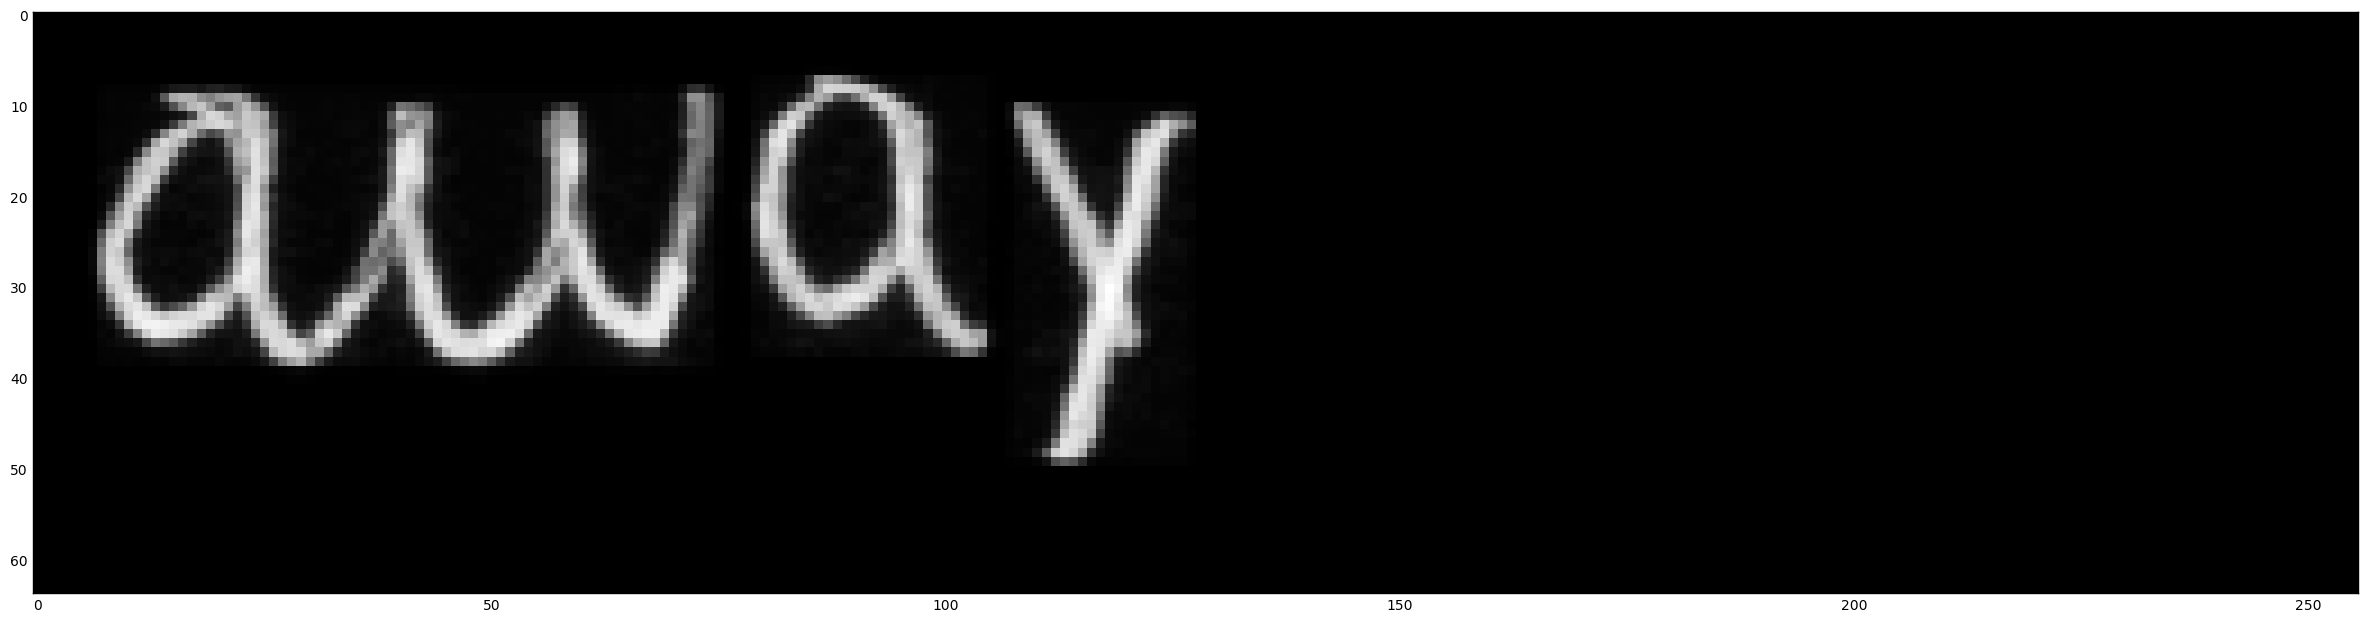

In [17]:
'''#Check data
i=5900
with h5py.File(data_path + file_name, mode='r') as hdf5_f:
    plt.imshow(hdf5_f.get('X_tst')[i])
    print(hdf5_f.get('image_length_tst')[i], hdf5_f.get('target_tst')[i], hdf5_f.get('target_length_tst')[i])'''